# What's in a Name: NBA Hall Of Fame

Comparison is the foundation of sports. We do it all the time when talking about teams -- who has a better record, who has a better chance to win the championship, etc. Similarly, we do it all the time when talking about players -- who's the biggest, strongest, fastest; who scores the most, who dominates the paint, etc. 

In basketball, specifically in the NBA, a common critique of comparing players across all time periods is that different eras emphasized differnet aspects of the game. Thus, some say that we should only compare players from within the same era, but we disagree. We want to explore this opinion head on -- are today's players truly so much better than the greats of decades past? Did Michael Jordan really go up against "mailmen" quality players who played basketball as a second job, or is that an oversimplifcation by LeBron fans?

We explore this grey area, and give quantifiable responses with respect to the quantifiable categories of the game. To do so, we pull from two datasets -- one that contains stats of active NBA players from the 2020-21 season, and one that contains stats of HOF inductees. We import and scrape these datasets, respectively -- with both requiring data cleaning/parsing. Both are stored in the Pandas DataFrame format, which gives us the ability to perform SQL-esque commands easily in a Python environment. We ask and answer (through data viz) multiple questions that compare the two eras, and equally the players within each era. 

We end by using ML techniques to predict whether a given active NBA player will enter the HOF based on their most recent performance. We understand that this model may underfit/overfit certain players (who are at the start/end of their careers), but for the most part, it will give us another valuable metric for comparison between eras.


In [204]:
# Data Collection - Pt.1
# Import the first dataset, found here: https://www.kaggle.com/umutalpaydn/nba-20202021-season-player-stats?select=nba2021_per_game.csv

from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# pd.set_option("display.max_rows", None, "display.max_columns", None)
nba2021_df = pd.read_csv('nba2021_per_game.csv')

nba2021_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,PF,21,MIA,28,2,14.6,2.6,4.4,0.590,...,0.561,1.3,2.7,4.0,0.6,0.4,0.5,1.0,1.9,6.5
1,Jaylen Adams,PG,24,MIL,6,0,2.8,0.2,1.3,0.125,...,0.000,0.0,0.5,0.5,0.3,0.0,0.0,0.0,0.2,0.3
2,Steven Adams,C,27,NOP,27,27,28.1,3.5,5.8,0.603,...,0.468,4.3,4.6,8.9,2.1,1.0,0.6,1.7,1.9,8.0
3,Bam Adebayo,C,23,MIA,26,26,33.6,7.4,12.9,0.573,...,0.841,1.9,7.3,9.2,5.3,1.0,1.0,3.0,2.6,19.9
4,LaMarcus Aldridge,C,35,SAS,18,18,26.7,5.9,12.5,0.476,...,0.762,0.8,3.5,4.3,1.9,0.4,0.9,0.9,1.5,14.1


In [205]:
# Data Parsing - Pt.1
# Clean the table by making sure all player entries are unique

players = nba2021_df.groupby('Player')

mult_teams = []
for player, player_df in players:
    if len(player_df.index) > 1:
        mult_teams.append(player)

for idx, row in nba2021_df.iterrows():
    # if a player played for multiple teams, we only want to keep their total stats
    if row.Player in mult_teams and row.Tm != 'TOT':
        nba2021_df = nba2021_df.drop([idx])

for player in mult_teams:
    # confirming that every player who played for multiple teams now only has one row (uniqueness)
    print(player, nba2021_df[nba2021_df.Player == player].shape[0])

Alex Len 1
Dennis Smith Jr. 1
Derrick Rose 1
James Harden 1
Jarrett Allen 1
Rodions Kurucs 1
Taurean Prince 1
Victor Oladipo 1


In [206]:
# Data Collection - Pt.2
# Now that we have a fully unique datatset of current players, lets study HOF players (scrape data using Requests + BS4)

URL = 'https://www.basketball-reference.com/awards/hof.html'

req = requests.get(URL)
soup = bs(req.content, 'html.parser')

table = soup.find('table').prettify()
hof_df = pd.read_html(table, flavor = 'bs4')[0]

hof_df.head()


Unnamed: 0_level_0                                 Unnamed: 1_level_0  \
                Year                                               Name   
0               2020                                    Patrick Baumann   
1               2020                        Kobe Bryant  Player  /  Oly   
2               2020                             Tamika Catchings  WNBA   
3               2020  Tim Duncan  Player  /  Coach  /  Oly  /  CBB  ...   
4               2020                      Kevin Garnett  Player  /  Oly   

  Unnamed: 2_level_0 Unnamed: 3_level_0 Per Game                       \
            Category                  G      PTS   TRB  AST  STL  BLK   
0        Contributor                NaN      NaN   NaN  NaN  NaN  NaN   
1             Player               1346     25.0   5.2  4.7  1.4  0.5   
2             Player                NaN      NaN   NaN  NaN  NaN  NaN   
3             Player               1392     19.0  10.8  3.0  0.7  2.2   
4             Player               1462     17.8  10.0  3.7  1.3  1.4   

  Shooting             Advanced       Unnamed: 14_level_0 Coaching            \
       FG%   3P%   FT%       WS WS/48 Unnamed: 14_level_1        G    W    L   
0      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN  NaN   
1     .447  .329  .837    172.7  .170                 NaN      NaN  NaN  NaN   
2      NaN   NaN   NaN      NaN   NaN                 NaN      NaN  NaN  NaN   
3     .506  .179  .696    206.4  .209                 NaN      NaN  NaN  NaN   
4     .497  .275  .789    191.4  .182                 NaN      NaN  NaN  NaN   

        
  W/L%  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN

In [207]:
# Data Parsing - Pt.2

# The website has data as a multi-index, but we don't need the top level
hof_df.columns = hof_df.columns.droplevel()

# The table also contains non-player data, this isn't helpful to us
for idx, row in hof_df.iterrows():
   if row.Category != 'Player':
       hof_df = hof_df.drop([idx])

# Drop WNBA players since we're only studying NBA
for idx, row in hof_df.iterrows():
    if 'WNBA' in row.Name:
        hof_df = hof_df.drop(idx)

# The Name category has some extra stuff, lets drop it to only <firstName lastName> 
# NOTE: we could just do this w a one-line lambda but we have some special cases with nicknames 
def fix_name(name):
    name_list = name.split()
    if len(name_list) == 2:     # if name is already in the right format
        return name
    new_name = ''
    for word in name_list:
        if word == 'Player':
            break
        new_name += word + ' '
    return new_name[:-1]     

hof_df['Name'] = hof_df['Name'].apply(lambda x: fix_name(x))

# Drop unnecessary cols:
hof_df = hof_df.drop(columns=['Unnamed: 14_level_1', 'G', 'W', 'L', 'W/L%'], axis=1)

hof_df = hof_df.sort_values(by=['Year'])

# Some non-NBA players are still in the Hall of Fame data frame
# Drop rows of the df that have PTS listed as NaN. This will remove all non-NBA players
hof_df = hof_df.dropna(subset=['PTS'])

# Cast the numbers in the main categories into floating points from strings (to prep data for analysis)
hof_df["Year"] = pd.to_numeric(pd.Series(hof_df["Year"])) 
hof_df["PTS"] = pd.to_numeric(pd.Series(hof_df["PTS"])) 
hof_df["TRB"] = pd.to_numeric(pd.Series(hof_df["TRB"])) 
hof_df["AST"] = pd.to_numeric(pd.Series(hof_df["AST"])) 
hof_df["BLK"] = pd.to_numeric(pd.Series(hof_df["BLK"])) 
hof_df["STL"] = pd.to_numeric(pd.Series(hof_df["STL"])) 

hof_df.head()

,Year,Name,Category,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
529,1959,George Mikan,Player,23.1,13.4,2.8,NaN,NaN,.404,NaN,.782,108.7,.249
512,1960,Ed Macauley,Player,17.5,7.5,3.2,NaN,NaN,.436,NaN,.761,100.4,.196
495,1961,Andy Phillip,Player,9.1,4.4,5.4,NaN,NaN,.368,NaN,.695,60.8,.101
440,1970,Bob Davies,Player,14.3,2.9,4.9,NaN,NaN,.378,NaN,.759,49.7,.148
434,1971,Bob Cousy,Player,18.4,5.2,7.5,NaN,NaN,.375,NaN,.803,91.1,.139


### Exploratory Data Analysis

Note, that by sorting the df, we see that certain metrics were not recorded back in the day (STL, BLK, 3P%). This alone is testament of the fact that the game has changed, and consequently, so have the factors that determine HOF worthiness. Let's move on to statistics that we do have, and explore how they vary through different eras.


(0.0, 23.955)

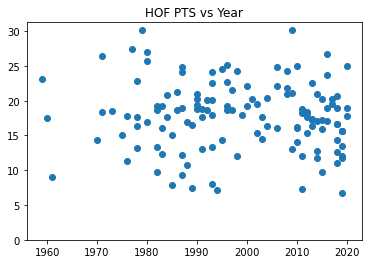

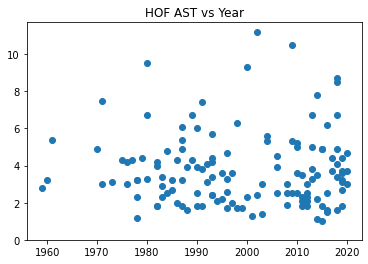

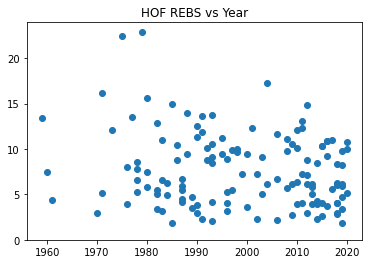

In [208]:
# Show a visual of how stats of hall of famers have changed through the years
plt.scatter(hof_df["Year"], hof_df["PTS"])
plt.title("HOF PTS vs Year")
plt.ylim(0)

plt.figure()
plt.scatter(hof_df["Year"], hof_df["AST"])
plt.title("HOF AST vs Year")
plt.ylim(0)

plt.figure()
plt.scatter(hof_df["Year"], hof_df["TRB"])
plt.title("HOF REBS vs Year")
plt.ylim(0)

From the plots above, it looks like Hall of Famers haven't really varied too much in terms of average number of points scored per game or assists per game. However, it is very interesting how the number of rebounds has decreased in the past few years - might have to do with how the league has gotten smaller with less dominant big men (the Steph Curry effect -- more spacing, more deep shooting, less interaction in the paint -> less rebounds)

A problem with these graphs: not everyone has been inducted 5 years after they played. Some players inducted in the past few years have played way back in the 1960s or 70s, and are being inducted now. These graphs don't necessarily represent when the players actually played.

### Let's focus on points for a second.

We create a linear regression model to see overall trend in HOF PTS across the years. We predict that PPG would be increasing over the years since a common claim is that players have become more skilled in scoring the ball, especially in the context of a less defensive game (due to rule changes) that lends itself to high-scoring results


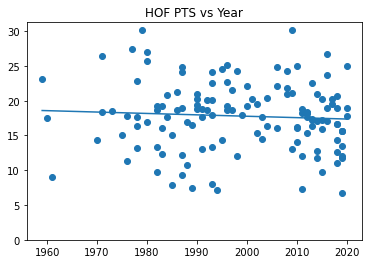

In [209]:
plt.figure()
plt.scatter(hof_df["Year"], hof_df["PTS"])
plt.title("HOF PTS vs Year")
plt.ylim(0)
m,b = np.polyfit(hof_df["Year"], hof_df["PTS"], 1)
plt.plot(hof_df["Year"], m*hof_df["Year"] + b)

Our model shows us that average PPG of HOF players over the years has not changed much, so our initial hypothesis was wrong. After seeing the distribution and the linear regression model, it makes sense as to why this is the case. While it can be assumed players have been more skilled in scoring the ball, players have become more skilled defensively as well. In the old NBA, the skill gap was too much between very skilled players and the average player which you could see through Wilt Chamberlein's career, as he even scored 100 points in a 1962 game. So across time, PPG was balanced overall as skill rose on both the defensive and offensive ends. 

<AxesSubplot:title={'center':'HOF PTS Residuals Vs. Year'}, xlabel='Year', ylabel='pts_rsd'>

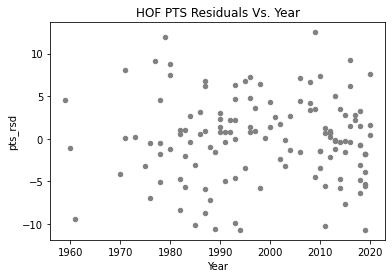

In [210]:
# plot residuals 
hof_df['pts_rsd'] = hof_df['PTS'] - (hof_df['Year']*m + b)
hof_df.plot.scatter('Year', 'pts_rsd', color='grey', title='HOF PTS Residuals Vs. Year')

The residuals also show evidence of a linear model, due to their lack of pattern and even, non-conical distribution across both sides of 0 -- this pattern is constant, linear, and almost 0 in terms of change per year. Again, this confirms that points have not dramatically skyrocketed overall

Next we'll try to compare how Hall of Famers with today's players. To do this we will build a "footprint" for these two categories, by showing what the average hall of famer's stats are, and the stats for the average player today.

In [211]:
# build a footprint of the "average nba player today" by finding the mean points, rebounds, assists, steals, and blocks scored today
curr_points = np.mean(nba2021_df["PTS"])
curr_assists = np.mean(nba2021_df["AST"])
curr_rebounds = np.mean(nba2021_df["TRB"])
curr_blocks = np.mean(nba2021_df["BLK"])
curr_steals = np.mean(nba2021_df["STL"])

# build a footprint of the average hall of famer by finding the mean in the same fashion as above
hof_points = np.mean(hof_df["PTS"])
hof_assists = np.mean(hof_df["AST"])
hof_rebounds = np.mean(hof_df["TRB"])
hof_blocks = np.mean(hof_df["BLK"])
hof_steals = np.mean(hof_df["STL"])

Text(0.5, 1.0, 'Steals')

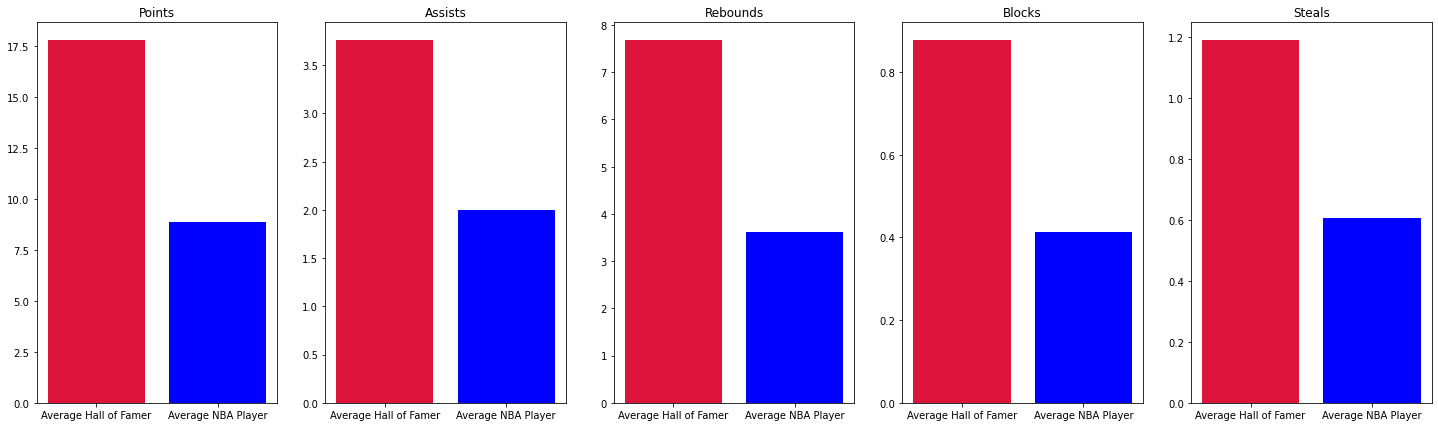

In [212]:
# compare the average player today with the average hall of famer across all categories

plt.figure(figsize=(25, 7))

colors = ['crimson', 'blue']

plt.subplot(1, 5,1)
plt.bar(["Average Hall of Famer","Average NBA Player"], [hof_points, curr_points],color=colors)
plt.title("Points")

plt.subplot(1, 5,2)
plt.bar(["Average Hall of Famer", "Average NBA Player"], [hof_assists, curr_assists],color=colors)
plt.title("Assists")

plt.subplot(1, 5, 3)
plt.bar(["Average Hall of Famer", "Average NBA Player"], [hof_rebounds, curr_rebounds],color=colors)
plt.title("Rebounds")

plt.subplot(1, 5, 4)
plt.bar(["Average Hall of Famer", "Average NBA Player"], [hof_blocks, curr_blocks],color=colors)
plt.title("Blocks")

plt.subplot(1, 5, 5)
plt.bar(["Average Hall of Famer", "Average NBA Player"], [hof_steals,curr_steals],color=colors)
plt.title("Steals")

It's interesting how the ratio between an average player's stats and a hall of famers stats are *nearly the same* across categories (2:1). The bars are almost perfectly aligned across the above graphs. 

In [213]:
# Method to calculate average of a category given DataFrame and category name
def calc_category_average(hof_df, category):
    player_category_stat = [float(stat) for stat in hof_df[category]]
    player_category_stat = list(filter(lambda x: np.isnan(x) == False , player_category_stat))
    avg_stat = sum(player_category_stat) / float(len(player_category_stat))
    return avg_stat

#avg_games = calc_category_average(hof_df, 'G')
avg_pts = calc_category_average(hof_df, 'PTS')
avg_trb = calc_category_average(hof_df, 'TRB')
avg_ast = calc_category_average(hof_df, 'AST')
avg_stl = calc_category_average(hof_df, 'STL')
avg_blk = calc_category_average(hof_df, 'BLK')

avg_stats = [avg_pts, avg_trb, avg_ast, avg_stl, avg_blk]

In [214]:
avg_stats = [hof_points, hof_rebounds, hof_assists, hof_steals, hof_blocks]

def get_player_stats(hof_df, player_name):
    for i, row in hof_df.iterrows():
        if row['Name'] == player_name:
            return [float(row['PTS']), float(row['TRB']), float(row['AST']), float(row['STL']), float(row['BLK'])]

In the modern NBA, the "3 point shot" is a game changer. As the 3 point shot becomes more and more deadly, with more players attempting 3s as a means of scoring, we want to see how much has the 3 point shot evolved over time among HOF players. Most current HOF players aren't from the era of the 3 pointer as that era began 2013 upwards. We hypothesize that the average 3P% among HOF players won't be as high as the average 3P% from current players, because we believe that older pros did not care much about the 3-pointer in their time.

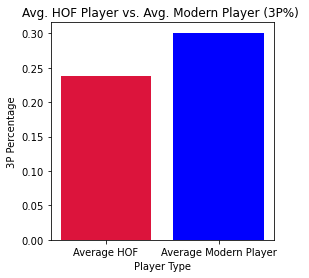

In [215]:
# Back to comparisons with today's players


avg_3pt_hof = calc_category_average(hof_df,'3P%')
avg_3pt_curr = calc_category_average(nba2021_df, '3P%')
fig = plt.figure(figsize = (4, 4))
plt.bar(['Average HOF', 'Average Modern Player'], [avg_3pt_hof, avg_3pt_curr], color =['crimson','blue'],width = 0.8)

plt.xlabel("Player Type")
plt.ylabel("3P Percentage")
plt.title("Avg. HOF Player vs. Avg. Modern Player (3P%) ")
plt.show()

Based on the results of our graph, our hypothesis that the average modern player's 3P% is higher than the average HOF player is correct. We see that the average modern player has about 6% higher 3P% than the average HOF player. As said earlier, this makes sense as players in today's era are more inclined to work on their 3-point shot as the 3 pointer's value is far higher than it used to be in the eras that most HOF players played in. 


The era that HOF players come from was also known as the "bully ball era" where players were very aggresive inside of the arc and more shots were taken inside of the arc. In the NBA it is more common to get blocked inside the arc since that's where layups occur so with that in mind, we hypothesize that the average HOF player would have more blocks than the average modern player, since the average HOF player would be from the "bully ball" era, more layups and inside shots occured than three pointers, so the probability for a block should be higher. Furthermore, as shown prior, three point shots have been more perfected and common among modern NBA players, and the 3 point shot usually is not as blocked as much as a field goal/inside shot. 

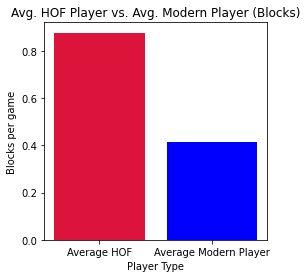

In [217]:

avg_blk_hof = calc_category_average(hof_df, 'BLK')
avg_blk_curr = calc_category_average(nba2021_df, 'BLK')

fig = plt.figure(figsize = (4, 4))
plt.bar(['Average HOF', 'Average Modern Player'], [avg_blk_hof, avg_blk_curr], color =['crimson','blue'],width = 0.8)

plt.xlabel("Player Type")
plt.ylabel("Blocks per game")
plt.title("Avg. HOF Player vs. Avg. Modern Player (Blocks)")
plt.show()

Based on the graph, we can conclude that our hypothesis is correct. The average HOF player has more blocks than the average modern nba player. This makes sense as more field goals, which are more frequenlty blocked than outside shots, were taken in the "bully ball" era than in the modern era where the 3 point shot rules. The difference is little more than double (~0.85 vs ~0.4) indiciating that the "bully ball" era was rougher and it was harder to score inside the paint at that time.

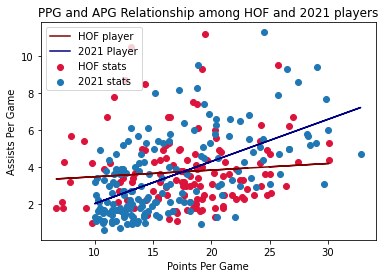

In [218]:
# How selfish does a HOF player have to be?
pts = np.array(hof_df['PTS']).reshape(-1,1)
ast = np.array(hof_df['AST']).reshape(-1,1)
model = linear_model.LinearRegression()
model.fit(pts, ast)
expected_ast = model.predict(pts)
plt.scatter(pts, ast, label='HOF stats',color='crimson')                           
plt.plot(pts, expected_ast, color = 'maroon', label='HOF player')                    
r1 = np.corrcoef(hof_df['PTS'], hof_df['AST'])
#2021 NBA players
pts = []
ast = []
for i,row in nba2021_df.iterrows():
    # Reject nba players with less than 10 PPG because those aren't players that we should consider against HOF players since 
    # they are not high scoring enough players to consider(<10 PPG is low scoring).
    if float(row['AST']) < 0.0 or np.isnan(row['AST']) or float(row['PTS']) < 10.0 or np.isnan(row['PTS']):
        continue
    pts.append(float(row['PTS']))
    ast.append(float(row['AST']))

r2 = np.corrcoef(pts, ast)
pts = np.array(pts).reshape(-1,1)
ast = np.array(ast).reshape(-1,1)
model = linear_model.LinearRegression()
model.fit(pts, ast)
expected_ast = model.predict(pts)
plt.scatter(pts, ast, label='2021 stats')                           
plt.plot(pts, expected_ast, color = 'navy', label='2021 Player')

plt.title('PPG and APG Relationship among HOF and 2021 players')          
plt.xlabel('Points Per Game')                                   
plt.ylabel('Assists Per Game') 
plt.legend()

In [219]:
print(r1) #R = .09 , indicating a weak correlation between PPG and APG among HOF players
print(r2) #R = 0.59, indicating a stronger correlation between PPG and APG among current nba players 


[[1.         0.08847423]
 [0.08847423 1.        ]]
[[1.         0.57572122]
 [0.57572122 1.        ]]


What this graph shows is the relationship between high scoring HOF and how selfish they were (not passing the ball) compared to the realtionship between high-scoring 2021 NBA players and how selfish they are. The HOF line (black line) shows a weakly positive trend (R=.09) between PPG and APG. This indicates that high scoring HOF players, who played during the "bully ball" era, did not share the ball as much. So yes, while they were scoring a lot of points, they were not getting their team as involved. When we look at the 2021 players stats, we see there is a very strong posititve trend (R=.59) between PPG and APG. This means that current high scoring NBA players, still share the ball a lot and get their team involved while scoring a lot of points. This means that it can be said that among the offensive powerhouses among both HOF players and 2021 players, 2021 offensive powerhouses are less selfish, and are more willing to share the ball. It can be said that they are more offensively complete since they are scoring more points and helping their team score points.

### Let's now zone in on a comparison entirely within the group of Hall of Fame players. 

In this example we will be examining a NBA player who we universally deem as an all-time great, seeing how Kobe Bryant compares to the average Hall of Fame inductee. We've established that HOFrs are some distance apart from today's average player, but there must be certain HOFrs that are a distance apart from their own class. We think that Kobe will be, at least in the category that defines the scoreboard: points.

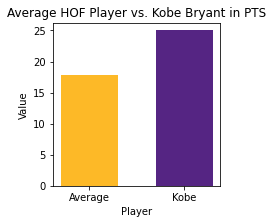

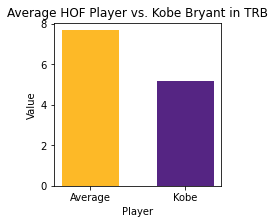

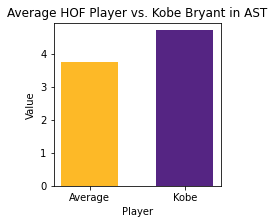

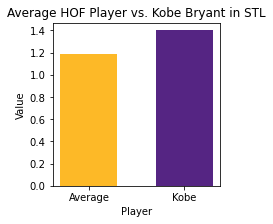

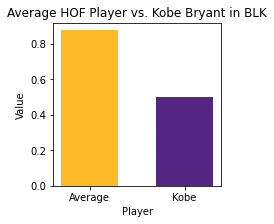

In [220]:
kobe_stats = get_player_stats(hof_df, 'Kobe Bryant')
categories = ['PTS', 'TRB', 'AST', 'STL', 'BLK']

for i in range(len(categories)):
    fig = plt.figure(figsize=(3, 3))
    plt.bar(['Average', 'Kobe'], [avg_stats[i], kobe_stats[i]], color =['#fdb927', '#552583'],width = 0.6)
    
    plt.xlabel("Player")
    plt.ylabel("Value")
    plt.title("Average HOF Player vs. Kobe Bryant in " + str(categories[i]))
    plt.show()

Based on the graphs comparing the average HOF player and Kobe Bryant in a variety of categories, we can see that Kobe Bryant was better offensively than the average HOF player with a higher PTS, and AST. He was however not as effective (compared to the average HOF player) in two main categories, both defenisve, and they were blocks and rebounds. However, with the most All NBA Defensive First Team selections of all time (9), Kobe was by no means lacking in that area. His steals, even, are barely testament of this as they are only slightly above the HOF average. This shows that numbers do not tell the entire story, and Kobe impacted the game in ways that may not be entirely quantifiable


### Machine Learning 

To train a model for HOF predictions, we need 2 distinct categories -- HOF and non HOF. We build those categories here

In [221]:
nba_df = pd.read_csv('all_seasons.csv')
nba_df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [222]:
# first we have to average stats for players who played multiple seasons, since the data is per season

# some stats are permanent (e.g. height, name, etc.). these on the other hand, vary by season:
stats = ['gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']

# each group is effectively one player's career stats, tabulated
players = nba_df.groupby('player_name')

# you can try Pandas' aggregate feature here, but we wanted to reduce rows in the existing table based on a subset of the columns, rather than creating an entirely new table 

# Goal: for all players that played multiple seasons (in the DF more than once, make it so that they're only in the DF once, and their stats are their career averages)
mult_seasons = []
first_season = {}   # slight hack so we only calculate each player's mean values once

# Go through every player, mark whoever plays >1 season
for player, player_df in players:
    if len(player_df.index) > 1:
        mult_seasons.append(player)
    for i, r in player_df.iterrows():
        first_season[player] = r.season
        break

# Go through main DF now (instead of the groupby object) and keep only one row per duplicative player to ensure uniqueness + averaging of career stats
for idx, row in nba_df.iterrows():
    # if a player played for multiple seasons, we only want to keep their avg stats
    player = row.player_name
    season = row.season
    if player in mult_seasons:
        if first_season[player] == season: 
            # calculate the mean, this should always be true at the first iteration since we iterate in order, chronologically through the years
            player_df = nba_df[nba_df['player_name'] == player]
            n = player_df.shape[0]            
            for stat in stats:
                nba_df.at[idx, stat] = sum(player_df[stat])/n
        else:
            nba_df = nba_df.drop([idx])

nba_df = nba_df.drop(['season'], axis=1)
nba_df.head()


,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,...,42,3.825,14.15,2.125,3.575,0.15125,0.33525,0.07925,0.44575,0.0835
1,1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,...,15,1.500,1.35,0.400,-8.450,0.08950,0.16350,0.17500,0.37000,0.1240
2,2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,...,9,0.800,1.00,0.400,-2.100,0.10500,0.10200,0.10300,0.37600,0.1480
3,3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,...,64,3.700,2.30,0.600,-8.700,0.06000,0.14900,0.16700,0.39900,0.0770
4,4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,...,27,2.400,2.40,0.200,-11.200,0.10900,0.17900,0.12700,0.61100,0.0400


In [223]:
# now that it's only unique players, lets see if theyre in the HOF or not

nba_df['hof'] = nba_df['player_name'].apply(lambda x: True if hof_df[hof_df['Name'] == x].shape[0] > 0 else False)

# rename some of the columns so that they are consistent with hof_df. This is important for our methods to work
non_hof_df = nba_df[nba_df['hof'] == False]
non_hof_df = non_hof_df.rename(columns={'player_name': 'Name', 'pts': "PTS", 'reb':"TRB", "ast": "AST"})


non_hof_df.head()

,Unnamed: 0,Name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,PTS,TRB,AST,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,hof
1,1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,...,1.500000,1.35,0.400000,-8.450000,0.0895,0.163500,0.175,0.370,0.124000,False
2,2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,...,0.800000,1.00,0.400000,-2.100000,0.1050,0.102000,0.103,0.376,0.148000,False
3,3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,...,3.700000,2.30,0.600000,-8.700000,0.0600,0.149000,0.167,0.399,0.077000,False
4,4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,...,2.400000,2.40,0.200000,-11.200000,0.1090,0.179000,0.127,0.611,0.040000,False
5,5,Eddie Johnson,HOU,38.0,200.66,97.522280,Illinois,USA,1981,2,...,6.866667,1.80,0.833333,-6.866667,0.0250,0.121333,0.238,0.509,0.089333,False


In [224]:
# We now have 2,201 non hall of famers in the non_hof_df and 134 hall of famers in the hof_df set
jose = non_hof_df[non_hof_df["Name"] == "Jose Calderon"] #store Jose Calderon's data for later

In [226]:
# Cleaning and preparing the non_hof_df

# Remove undrafted players from data set. We do this because we need ways of filtering players based upon their playing status.

index_names = non_hof_df[non_hof_df['draft_year'] == "Undrafted"].index
non_hof_df.drop(index_names, inplace = True)

# convert draft year values to numeric
non_hof_df["draft_year"] = pd.to_numeric(pd.Series(non_hof_df["draft_year"])) 

# Since there could be potential hall of famers still paying today, we need players in our non hall of fame training
# set to be players who can't possibly be playing today. Vince Carter was the oldest player in the nba last year and
# he was drafted in 1998, so our non_hof_df will have to have players in the set who were drafted before '98, just 
# to be sure. 

# This now gives us 427 non hall of fame players who could not possibly be playing today


#store the players who have been drafted after 1998 in another data set, we will use this at the end
recent_players_df = non_hof_df[non_hof_df["draft_year"] >= 1998]

non_hof_df = non_hof_df[non_hof_df["draft_year"] < 1998]

In [227]:
# Modify the original method to only return points, rebounds, assists. This is because our non hof dataset doeesn't contain data for steals or blocks
def get_player_stats_v2(hof_df, player_name):
    for i, row in hof_df.iterrows():
        if row['Name'] == player_name:
            return [float(row['PTS']), float(row['TRB']), float(row['AST'])]

In [228]:
# Input: The DF, name of player, and a threshold representing the number of categories a player must be better than the average hall of famer at.
# Output: Returns True if player_name is adequate enough to be inducted into the hall of fame
def hofOrNah(player_name, threshold, df):
    playerStats = get_player_stats_v2(df, player_name)
    if playerStats == None:
        return False
    # iterate throgh stats and check if how many categories the given player is better than average at. This is their "score"
    score = 0
    if playerStats[0] > hof_points:
        score += 1
    if playerStats[1] > hof_rebounds:
        score += 1
    if playerStats[2] > hof_assists:
        score += 1

    #if they excel in enough categories over the threshold, return true.
    if score >= threshold:
        return True
    else: 
        return False


In [229]:
#Runs the training model on the hof and non-hof datasets and returns an accuracy percentagee for both classifications
#Input: The number of categories for the threshold (num_categories). Setting print_hof_results to true will display the output.
#Output: A tuple containing two floating point values representing the accuracies of hof and non_hof, respectively.
def train_model(num_categories, print_hof_results = False, print_non_hof_results = False):
    hof_count = 0
    non_hof_names = list(non_hof_df["Name"])
    hof_names = list(hof_df["Name"])

    # iterate through non hall of famers and classify them based on the category parameter
    if print_non_hof_results:
        print("\nHall of Fame Classifications for non Hall of Famers:")
    
    for i in range(int(len(non_hof_names)*1)):
        name = non_hof_names[i]
        if hofOrNah(name, num_categories, non_hof_df) == True:
            hof_count += 1
            if print_non_hof_results:
                print("YES", name, "should be a hall of famer")
        else:
            if print_non_hof_results:
                print("NO",name, "should not be a hall of famer")
    total = len(non_hof_df["Name"])
    accuracy = hof_count/total
    print("Accuracy of classifying non hall of famers:", 100 - (accuracy * 100), "%")
    non_hof_accuracy = 100 - (accuracy * 100)

    #iterate through hall of famers and classify them based on the category parameter
    hof_count = 0
    if print_hof_results:
        print("\nHall of Fame Classifications for Actual Hall of Famers:")

    for i in range(int(len(hof_names)*1)):
        name = hof_names[i]
        if hofOrNah(name, num_categories, hof_df) == True:
            hof_count += 1
            if print_hof_results:
                print("YES", name, "should be a hall of famer")
        else:
            if print_hof_results:
                print("NO",name, "should not be a hall of famer")

    total = len(hof_df["Name"])
    accuracy = hof_count/total
    
    print("Accuracy of classifying hall of famers:", accuracy * 100, "%")
    hof_accuracy = accuracy * 100

    return hof_accuracy, non_hof_accuracy

In [230]:
nhf_accuracy = []
hf_accuracy = []

In [231]:
#Threshold of 1
hf, nhf = train_model(1)
nhf_accuracy.append(nhf)
hf_accuracy.append(hf)

Accuracy of classifying non hall of famers: 92.50585480093677 %
Accuracy of classifying hall of famers: 85.82089552238806 %


In [232]:
#Threshold of 2
hf, nhf = train_model(2)
nhf_accuracy.append(nhf)
hf_accuracy.append(hf)

Accuracy of classifying non hall of famers: 98.82903981264637 %
Accuracy of classifying hall of famers: 45.52238805970149 %


In [233]:
#Threshold of 3
hf, nhf = train_model(3)
nhf_accuracy.append(nhf)
hf_accuracy.append(hf)

Accuracy of classifying non hall of famers: 99.76580796252928 %
Accuracy of classifying hall of famers: 5.223880597014925 %


The cells above show that the accuracy tends to decrease for the hf_category, and increase for the non_hf category as the number for the threshold increases. Let's plot this below to see how it looks.

(0.0, 100.0)

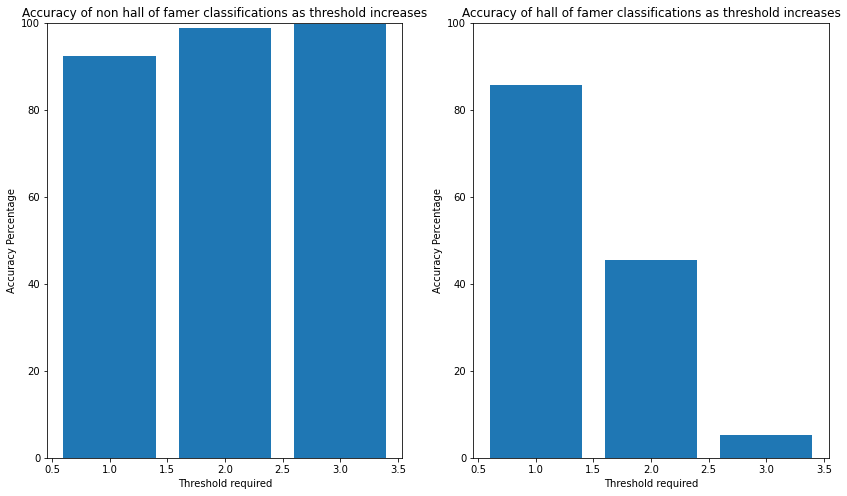

In [234]:
#plot the figures
plt.figure(figsize=(14, 8))
plt.subplot(1,2,1)
plt.title("Accuracy of non hall of famer classifications as threshold increases")
plt.bar(range(1,4), nhf_accuracy)
plt.ylim(0, 100)
plt.xlabel("Threshold required")
plt.ylabel("Accuracy Percentage")

plt.subplot(1, 2, 2)
plt.title("Accuracy of hall of famer classifications as threshold increases")
plt.bar(range(1,4), hf_accuracy)
plt.xlabel("Threshold required")
plt.ylabel("Accuracy Percentage")
plt.ylim(0, 100)


## Training Results

From these results, we can see that as we increase the number of categories as the threshold for classifying a hall of famer, the model overfits to non hall of famers, since the non-HOF accuracy approaches 100%, but the HOF classification accuracy decreases drastically. One thing we could try to do to increase our training accuracy is using more categories, instead of just points rebounds and assists. However, our data set constrains us to using only these three since steals and blocks were not recorded in the NBA prior to 1973. Maybe we can try using some variables such as rebound usage percentage, assist percentage, etc. These are values that exist in our all_seasons dataset that could potentially be examined. 

As of right now we can conclude that a 1 category threshold for admitting a player into the hall of fame is likely the best, since we have 92% accuracy in classifying people who don't belong, while also achieving an accuracy of 85% in people who do belong. You can see this from the chart above.

Sometimes players are inducted for honorary purposes, while not having sufficient stats or achievements to support them being in the hall of fame. Looking at the output below can help us examine these outlying cases too. For example, towards the end of the results below, you can see Bobby Jones was recently inducted in the hall of fame. Bobby Jones played in the 1970's during a different era of the NBA, and as a result, may have lower stats compared to hall of fame calibre players today, which is why he wasn't classified as HOF. Our model doesn't yet capture how a hall of fame classification is dependant upon the era the player played in.

In [235]:
train_model(1, print_hof_results = False)

Accuracy of classifying non hall of famers: 92.50585480093677 %
Accuracy of classifying hall of famers: 85.82089552238806 %


(85.82089552238806, 92.50585480093677)

## Which of Today's NBA players will make it to the Hall of Fame?
Let's run our classifier on today's players and see who will make into the hall of fame. 

First let's run our predictive model using a parameter of 1. 

In [236]:
current_player_names = list(nba2021_df["Player"])
predicted_hall_of_famers = []
for i in range(int(len(current_player_names)*1)):
        name = current_player_names[i]
        if hofOrNah(name, 1, recent_players_df) == True:
            print("YES based on his career averages so far,", name, "will be a hall of famer")
            predicted_hall_of_famers.append(name)

YES based on his career averages so far, Steven Adams will be a hall of famer
YES based on his career averages so far, Bam Adebayo will be a hall of famer
YES based on his career averages so far, LaMarcus Aldridge will be a hall of famer
YES based on his career averages so far, Jarrett Allen will be a hall of famer
YES based on his career averages so far, Giannis Antetokounmpo will be a hall of famer
YES based on his career averages so far, Carmelo Anthony will be a hall of famer
YES based on his career averages so far, D.J. Augustin will be a hall of famer
YES based on his career averages so far, Deandre Ayton will be a hall of famer
YES based on his career averages so far, Lonzo Ball will be a hall of famer
YES based on his career averages so far, Bradley Beal will be a hall of famer
YES based on his career averages so far, Eric Bledsoe will be a hall of famer
YES based on his career averages so far, Devin Booker will be a hall of famer
YES based on his career averages so far, Malcol

Now let's try running it with a parameter of 2 (below)

In [237]:
current_player_names = list(nba2021_df["Player"])
predicted_hall_of_famers = []
for i in range(int(len(current_player_names)*1)):
        name = current_player_names[i]
        if hofOrNah(name, 2, recent_players_df) == True:
            print("YES based on his career averages so far,", name, "will be a hall of famer")
            predicted_hall_of_famers.append(name)

YES based on his career averages so far, LaMarcus Aldridge will be a hall of famer
YES based on his career averages so far, Giannis Antetokounmpo will be a hall of famer
YES based on his career averages so far, Bradley Beal will be a hall of famer
YES based on his career averages so far, Devin Booker will be a hall of famer
YES based on his career averages so far, DeMarcus Cousins will be a hall of famer
YES based on his career averages so far, Stephen Curry will be a hall of famer
YES based on his career averages so far, Anthony Davis will be a hall of famer
YES based on his career averages so far, Kevin Durant will be a hall of famer
YES based on his career averages so far, Joel Embiid will be a hall of famer
YES based on his career averages so far, Blake Griffin will be a hall of famer
YES based on his career averages so far, James Harden will be a hall of famer
YES based on his career averages so far, Kyrie Irving will be a hall of famer
YES based on his career averages so far, LeB

Based on the two different outputs, it seems that although a parameter of 1 gave us the best accuracy in training results, we looked at the lists and realized that a parameter of 2 gave us more "realistic" results. The first list contains players who are all very good, but players who fans or experts would say are not necessarily hall of fame calibre. For example, players like Jeff Teague, Marcus Smart, Collin Sexton, are solid players, but most people wouldn't say they belong in the Hall of Fame. The second list however,gave us more "realistic" names that we could look at and agree that these players are the best of the best and therefore are all hall of famers. The problem that arises is that above, we concluded that a parameter of 1 was the more accurrate parameter. So why is this happening? 

The first explanation is that our predictive model is only for players who have retired. The data set we are using contains players who are very young, and still in their prime. These players have not had a chance to play in the "declining" stage of their career, so as a result, their career averages are unusually high, compared to where they will be when they retire. 

Another reason could be that the standards for Hall of Famers has gone for players who have played over the past few decades. We saw how players like Bobby Jones, don't necessarily have high stats by today's nba standards, but it was high relative to the time they played in. Therefore, to make a better prediction, it may be better to compute the averages of hall of famers who played within the last 1-2 decades as a basis for whether today's players would make it. As the game has evolved, it may be better to use weight data from more recent eras higher than data from half a century ago. The standards for the Hall of Fame have definitely changed over time.

Overall, our model did what we told it to do. We have a lot of ideas for improving the model by adding more categories, weighing the different eras differently, and perhaps creating separate models by the position the player plays. We also expect to recieve better results when looking at players who have finished their career, and are waiting to be inducted in to the hall of fame. 

## Exploratory Analysis: Is Jose Calderon a Hall of Famer?
Since our instructor is named Jose Calderon, we thought it would be funny to see if the other Jose Calderon, who was point guard in the NBA from 2005 - 2018, would be classified as a Hall of Famer according to our model. 

In [254]:
name = "Jose Calderon"
if hofOrNah(name, 1, recent_players_df) == True:
    print("YES based on his career averages so far,", name, "will be a hall of famer")
else:
    print("NO", name, "will not be a hall of famer")

NO Jose Calderon will not be a hall of famer


Unfortunately, Jose Calderon was not classified as a hall of famer. Below you can see his career averages.

In [243]:
jose_stats = get_player_stats_v2(jose, "Jose Calderon")
print(jose_stats)

[8.457142857142857, 2.3785714285714286, 5.528571428571427]


## Jose Calderon vs The Average Hall of Famer

Below we will plot Jose Calderon's stats to compare with the average hall of famer in the NBA.

Text(0.5, 1.0, 'Rebounds')

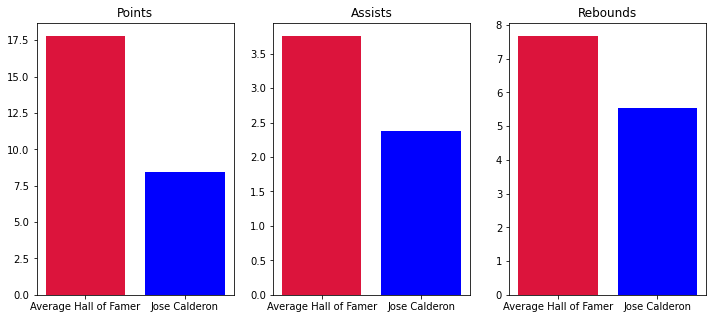

In [259]:
plt.figure(figsize=(12,5))
plt.subplot(1, 3,1)
plt.bar(["Average Hall of Famer","Jose Calderon"], [hof_points, jose_stats[0]],color=colors)
plt.title("Points")

plt.subplot(1, 3, 2)
plt.bar(["Average Hall of Famer","Jose Calderon"], [hof_assists, jose_stats[1]],color=colors)
plt.title("Assists")

plt.subplot(1, 3, 3)
plt.bar(["Average Hall of Famer","Jose Calderon"], [hof_rebounds, jose_stats[2]],color=colors)
plt.title("Rebounds")

## Conclusion

As you can see Jose Calderon was actually a pretty solid nba player, but he wasn't quite up to par with the average hall of fame level. It's possible that if he was able to bring up his career averages in assists or rebounds up, that he could have potentially reached the classification of Hall of Famer. Perhaps Jose Calderon is better suited in the software engineering industry :)

Thank you for reading through our data science tutorial. This project has allowed us to gain a new appreciation for the different eras of the NBA and it has allowed us to see how certain statistics can have an influence on how a player's legacy could be regarded. We learned that the year influences how a player is regarded in the history of the NBA. We also gained lots of valuable experience with machine learning, and even though we may not have done it perfectly, we are even more interested in learning about it further in CSMC422. 